# Deep Learning For Recommendation Systems

In [1]:
import pandas as pd

In [2]:
dataset = pd.read_csv('product_review_dataset.csv')

In [3]:
dataset_for_knn = dataset.drop(['Unnamed: 0'], axis=1)

In [4]:
# Removing all users who have not provided more than 1 rating
filtered_df = dataset_for_knn.groupby('userId').filter(lambda x : len(x) > 1)
n_users = filtered_df.nunique()[0]
n_items = filtered_df.nunique()[1]
print(filtered_df.nunique())

userId       71894
productId     5198
rating           4
dtype: int64


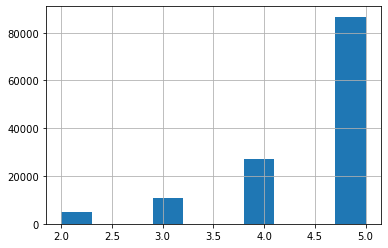

In [5]:
filtered_df = filtered_df.drop(filtered_df.query('rating == 5').sample(frac=0.4).index)
filtered_df['rating'].hist()

In [6]:
filtered_df.shape

(129909, 3)

## Deep Learning Based Models

In [7]:
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers.embeddings import Embedding
from keras.optimizers import Adam
from keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import pickle
from keras.layers import Concatenate, Dense, Dropout
from keras.layers import Input, Embedding, Flatten, Dot, Add, Lambda, Activation, Reshape, Concatenate, Dense
import numpy as np
from sklearn.metrics import accuracy_score

In [8]:
def top_ten_predicted(model, user, items):
    predictions = model.predict([np.array([user]*len(items)), items])
    predictions_df = pd.DataFrame(predictions, columns=['ratings'])
    item_id_df = pd.DataFrame(item_encoding, columns = ['itemId'])
    item_id_df['ratings'] = predictions_df['ratings']
    top_10 = item_id_df.sort_values(by = ['ratings'], ascending=False)[:10]
    return top_10['itemId'].values

In [9]:
def top_ten_actual(df, user):
    return df[df['userId'] == user].sort_values(by = ['rating'], ascending=False)[:100]['productId'].values

In [10]:
user_enc = LabelEncoder()
filtered_df['userId'] = user_enc.fit_transform(filtered_df['userId'].values)

In [11]:
item_enc = LabelEncoder()
filtered_df['productId'] = item_enc.fit_transform(filtered_df['productId'].values)

In [12]:
item_encoding = filtered_df['productId'].unique()

In [13]:
user_encoding = filtered_df['userId'].unique()

In [14]:
item_encoding

array([   0,    1,    2, ..., 4904, 4900, 4901])

In [15]:
user_encoding

array([28820, 21466, 33571, ..., 63481, 38099, 53404])

In [16]:
#np.save('item_encoder.npy', item_enc.classes_)
output = open('item_encoder.pkl', 'wb')
pickle.dump(item_enc, output)
output.close()

In [17]:
#np.save('user_encoder.npy', user_enc.classes_)
output = open('user_encoder.pkl', 'wb')
pickle.dump(user_enc, output)
output.close()

In [18]:
X = np.array([filtered_df['userId'], filtered_df['productId']]).T
y = np.array(filtered_df['rating']).T

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((116918, 2), (12991, 2), (116918,), (12991,))

In [20]:
X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [21]:
class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal',
                      embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        return x

In [22]:
def RecommenderNet(n_users, n_movies, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    
    movie = Input(shape=(1,))
    m = EmbeddingLayer(n_movies, n_factors)(movie)
    
    x = Concatenate()([u, m])
    x = Dropout(0.05)(x)
    
    x = Dense(10, kernel_initializer='he_normal')(x)
    x = Activation('relu')(x)
    x = Dropout(0.5)(x)
    
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)
    model = Model(inputs=[user, movie], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)
    return model

In [23]:
model = RecommenderNet(n_users, n_items, 50, 1, 5)
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
1827/1827 [==============================] - 34s 19ms/step - loss: 1.1637 - val_loss: 0.5894
Epoch 2/20
1827/1827 [==============================] - 35s 19ms/step - loss: 0.4176 - val_loss: 0.6044
Epoch 3/20
1827/1827 [==============================] - 35s 19ms/step - loss: 0.3202 - val_loss: 0.6238
Epoch 4/20
1827/1827 [==============================] - 35s 19ms/step - loss: 0.2759 - val_loss: 0.6489
Epoch 5/20
1827/1827 [==============================] - 35s 19ms/step - loss: 0.2560 - val_loss: 0.6718
Epoch 6/20
1827/1827 [==============================] - 35s 19ms/step - loss: 0.2470 - val_loss: 0.6855
Epoch 7/20
1827/1827 [==============================] - 37s 20ms/step - loss: 0.2419 - val_loss: 0.6841
Epoch 8/20
1827/1827 [==============================] - 38s 21ms/step - loss: 0.2335 - val_loss: 0.6785
Epoch 9/20
1827/1827 [==============================] - 52s 28ms/step - loss: 0.2333 - val_loss: 0.6838
Epoch 10/20
1827/1827 [==============================] - 53s 29m

In [24]:
prediction = np.round(model.predict(X_test_array)).astype('int')
accuracy_score(np.round(y_test).astype('int'), np.round(prediction).astype('int'))

0.629820645061966

In [25]:
top_ten_predicted(model, 3, item_encoding)

array([2009, 4130, 3317, 4181, 4692, 4386, 1825, 4096, 4293, 4615])

In [26]:
def NeuralCollabrativeFiltering(n_users, n_items, n_factors, min_rating, max_rating):
    
    item_input = Input(shape=[1], name='Item')
    
    item_embedding_mf = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                                  embeddings_initializer='he_normal',
                                  name='ItemEmbeddingMF')(item_input)
    item_vec_mf = Flatten(name='FlattenItemMF')(item_embedding_mf)
    
    
    item_embedding_mlp = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                                embeddings_initializer='he_normal',
                               name='ItemEmbeddingMLP')(item_input)
    item_vec_mlp = Flatten(name='FlattenItemMLP')(item_embedding_mlp)
    
    user_input = Input(shape=[1], name='User')
    
    user_embedding_mf = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6), 
                                embeddings_initializer='he_normal',
                               name='UserEmbeddingMF')(user_input)
    user_vec_mf = Flatten(name='FlattenUserMF')(user_embedding_mf)
    
    user_embedding_mlp = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='he_normal',
                               name='UserEmbeddingMLP')(user_input)
    user_vec_mlp = Flatten(name='FlattenUserMLP')(user_embedding_mlp)
    
    DotProductMF = Dot(axes=1, name='DotProductMF')([item_vec_mf, user_vec_mf])
    
    ConcatMLP = Concatenate(name='ConcatMLP')([item_vec_mlp, user_vec_mlp])
    
    Dense_1 = Dense(50, name="Dense1")(ConcatMLP)
    Dense_2 = Dense(20, name="Dense2")(Dense_1)

    Concat = Concatenate(name="ConcatAll")([DotProductMF, Dense_2])
    
    Pred = Dense(1, name="Pred")(Concat)
    
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-5), name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-5), name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    PredAddBias = Add(name="AddBias")([Pred, item_bias_vec, user_bias_vec])
    
    y = Activation('sigmoid')(PredAddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    model = Model([user_input, item_input], rating_output)
    
    model.compile(loss='mean_squared_error', optimizer="adam")
    
    return model

In [27]:
n_factors = 40
model = NeuralCollabrativeFiltering(n_users, n_items, n_factors, 1, 5)

In [28]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Item (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
User (InputLayer)               [(None, 1)]          0                                            
__________________________________________________________________________________________________
ItemEmbeddingMLP (Embedding)    (None, 1, 40)        207920      Item[0][0]                       
__________________________________________________________________________________________________
UserEmbeddingMLP (Embedding)    (None, 1, 40)        2875760     User[0][0]                       
____________________________________________________________________________________________

In [29]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
1827/1827 [==============================] - 88s 47ms/step - loss: 0.7611 - val_loss: 0.5599
Epoch 2/20
1827/1827 [==============================] - 84s 46ms/step - loss: 0.3285 - val_loss: 0.5640
Epoch 3/20
1827/1827 [==============================] - 85s 46ms/step - loss: 0.1497 - val_loss: 0.5817
Epoch 4/20
1827/1827 [==============================] - 85s 47ms/step - loss: 0.0900 - val_loss: 0.5753
Epoch 5/20
1827/1827 [==============================] - 84s 46ms/step - loss: 0.0811 - val_loss: 0.5665
Epoch 6/20
1827/1827 [==============================] - 81s 44ms/step - loss: 0.0753 - val_loss: 0.5689
Epoch 7/20
1827/1827 [==============================] - 80s 44ms/step - loss: 0.0718 - val_loss: 0.5642
Epoch 8/20
1827/1827 [==============================] - 82s 45ms/step - loss: 0.0705 - val_loss: 0.5641
Epoch 9/20
1827/1827 [==============================] - 90s 49ms/step - loss: 0.0670 - val_loss: 0.5578
Epoch 10/20
1827/1827 [==============================] - 90s 49m

In [30]:
prediction = np.round(model.predict(X_test_array)).astype('int')
accuracy_score(np.round(y_test).astype('int'), np.round(prediction).astype('int'))

0.6074205218997768

In [31]:
top_ten_predicted(model, 3, item_encoding)

array([ 311, 2785, 3317, 3116,  441, 1825,  963, 3147,  684, 4333])

In [32]:
def MatrixFactorization(n_users, n_items, n_factors, min_rating, max_rating):
    
    item_input = Input(shape=[1], name='Item')
    item_embedding = Embedding(n_items, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='glorot_normal',
                               name='ItemEmbedding')(item_input)
    item_vec = Flatten(name='FlattenItemE')(item_embedding)
    
    item_bias = Embedding(n_items, 1, embeddings_regularizer=l2(1e-6), 
                          embeddings_initializer='glorot_normal',
                          name='ItemBias')(item_input)
    item_bias_vec = Flatten(name='FlattenItemBiasE')(item_bias)

    user_input = Input(shape=[1], name='User')
    user_embedding = Embedding(n_users, n_factors, embeddings_regularizer=l2(1e-6),
                               embeddings_initializer='glorot_normal',
                               name='UserEmbedding')(user_input)
    user_vec = Flatten(name='FlattenUserE')(user_embedding)
    
    user_bias = Embedding(n_users, 1, embeddings_regularizer=l2(1e-6), 
                        embeddings_initializer='glorot_normal',
                          name='UserBias')(user_input)
    user_bias_vec = Flatten(name='FlattenUserBiasE')(user_bias)

    Concat = Concatenate(name='Concat')([item_vec, user_vec])
    ConcatDrop = Dropout(0.5)(Concat)

    kernel_initializer='he_normal'
    
    Dense_1 = Dense(10, kernel_initializer='glorot_normal', name="Dense1")(ConcatDrop)
    Dense_1_Drop = Dropout(0.5)(Dense_1)
    Dense_2 = Dense(1, kernel_initializer='glorot_normal', name="Dense2")(Dense_1_Drop)

    
    AddBias = Add(name="AddBias")([Dense_2, item_bias_vec, user_bias_vec])
    
    y = Activation('sigmoid')(AddBias)
    rating_output = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(y)
    
    model = Model([user_input, item_input], rating_output)
    
    model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.001))
    
    return model

In [33]:
n_factors = 50
model = MatrixFactorization(n_users, n_items, n_factors, 1, 5)

In [34]:
history = model.fit(x=X_train_array, y=y_train, batch_size=64, epochs=20,
                    verbose=1, validation_data=(X_test_array, y_test))

Epoch 1/20
1827/1827 [==============================] - 66s 36ms/step - loss: 1.0063 - val_loss: 0.5849
Epoch 2/20
1827/1827 [==============================] - 63s 34ms/step - loss: 0.4443 - val_loss: 0.5811
Epoch 3/20
1827/1827 [==============================] - 61s 34ms/step - loss: 0.3319 - val_loss: 0.6018
Epoch 4/20
1827/1827 [==============================] - 61s 34ms/step - loss: 0.2936 - val_loss: 0.6180
Epoch 5/20
1827/1827 [==============================] - 62s 34ms/step - loss: 0.2805 - val_loss: 0.6277
Epoch 6/20
1827/1827 [==============================] - 62s 34ms/step - loss: 0.2662 - val_loss: 0.6386
Epoch 7/20
1827/1827 [==============================] - 62s 34ms/step - loss: 0.2641 - val_loss: 0.6384
Epoch 8/20
1827/1827 [==============================] - 62s 34ms/step - loss: 0.2612 - val_loss: 0.6463
Epoch 9/20
1827/1827 [==============================] - 62s 34ms/step - loss: 0.2611 - val_loss: 0.6484
Epoch 10/20
1827/1827 [==============================] - 62s 34m

In [35]:
prediction = np.round(model.predict(X_test_array)).astype('int')
accuracy_score(np.round(y_test).astype('int'), np.round(prediction).astype('int'))

0.6303594796397506

In [36]:
model.save('first_model')

INFO:tensorflow:Assets written to: first_model/assets


In [37]:
top_ten_predicted(model, 3, item_encoding)

array([3317,  311,  963, 2867, 4333, 4577, 4692, 4037,  315, 4130])